In [2]:
# system
import os
from datetime import datetime
from datetime import timedelta

# data processing and plotting
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import yfinance as yahooFinance

# ml/dl
from pmdarima import auto_arima, AutoARIMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error

# trd
import MetaTrader5 as mt

---
# Download data

In [85]:
mt.initialize()
mt.login(152702909, open('../.pass', 'r').read().strip(), 'Exness-MT5Trial')
df = pd.DataFrame(mt.copy_rates_range('BTCUSD', mt.TIMEFRAME_D1, datetime(2023, 1, 1), datetime.now()))
mt.shutdown()

True

In [86]:
df.head()

,time,open,high,low,close,tick_volume,spread,real_volume
0,1672531200,16532.88,16619.48,16492.71,16603.49,79688,427,0
1,1672617600,16602.97,16773.48,16535.88,16665.66,82223,747,0
2,1672704000,16665.36,16773.61,16593.15,16662.49,82161,575,0
3,1672790400,16661.05,16988.17,16639.02,16837.79,83272,371,0
4,1672876800,16839.31,16868.59,16750.72,16814.80,82185,517,0


---
# Auxiliary

In [5]:
def tm_plot(dt, data, title='', xlabel='', ylabel='', figsize=(10, 7), style='fivethirtyeight'):
    # plt.style.use(style)
    plt.figure(figsize=figsize)
    plt.plot(dt, data)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

---
# Preprocess data

In [6]:
dfs = df.copy()

In [7]:
dfs.time = pd.to_datetime(df.time, unit='s', utc=False)
dfs.head()

,time,open,high,low,close,tick_volume,spread,real_volume
0,2023-01-01,16532.88,16619.48,16492.71,16603.49,79688,427,0
1,2023-01-02,16602.97,16773.48,16535.88,16665.66,82223,747,0
2,2023-01-03,16665.36,16773.61,16593.15,16662.49,82161,575,0
3,2023-01-04,16661.05,16988.17,16639.02,16837.79,83272,371,0
4,2023-01-05,16839.31,16868.59,16750.72,16814.80,82185,517,0


In [8]:
dfi = dfs.set_index('time')
dfi.head()

,open,high,low,close,tick_volume,spread,real_volume
time,,,,,,,
2023-01-01,16532.88,16619.48,16492.71,16603.49,79688,427,0
2023-01-02,16602.97,16773.48,16535.88,16665.66,82223,747,0
2023-01-03,16665.36,16773.61,16593.15,16662.49,82161,575,0
2023-01-04,16661.05,16988.17,16639.02,16837.79,83272,371,0
2023-01-05,16839.31,16868.59,16750.72,16814.80,82185,517,0


---
# Analysis

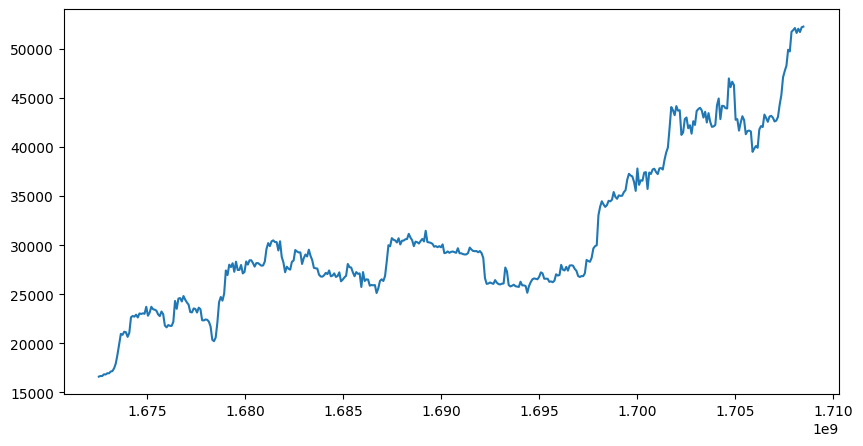

In [9]:
tm_plot(df.time, df.close, figsize=(10, 5))

<Figure size 640x480 with 0 Axes>

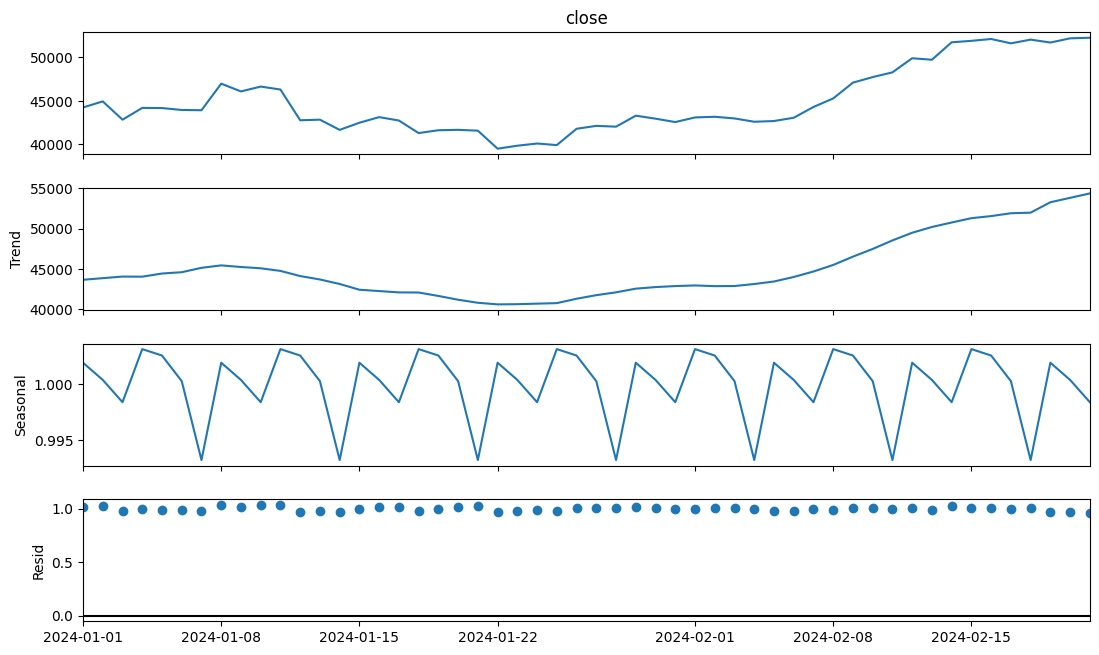

In [10]:
results = seasonal_decompose(dfi.loc[datetime(2024, 1, 1):].close, model='multiplicative', extrapolate_trend='freq')
fig = plt.figure()  
fig = results.plot()  
fig.set_size_inches(12, 7)
plt.show()

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

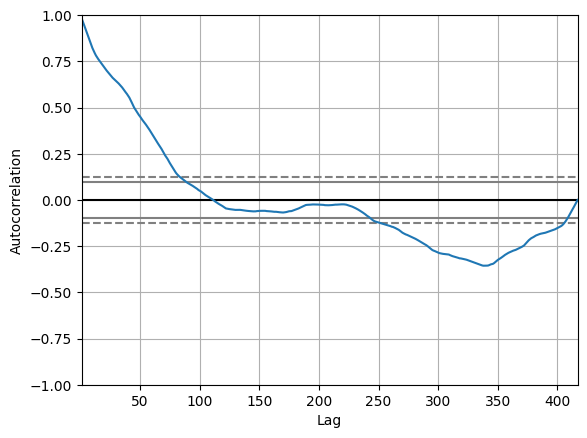

In [11]:
pd.plotting.autocorrelation_plot(dfi.close)

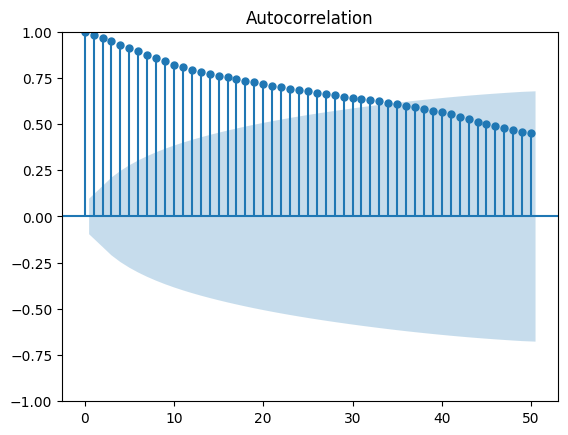

In [12]:
plot_acf(dfi.close, lags=50)
plt.show()

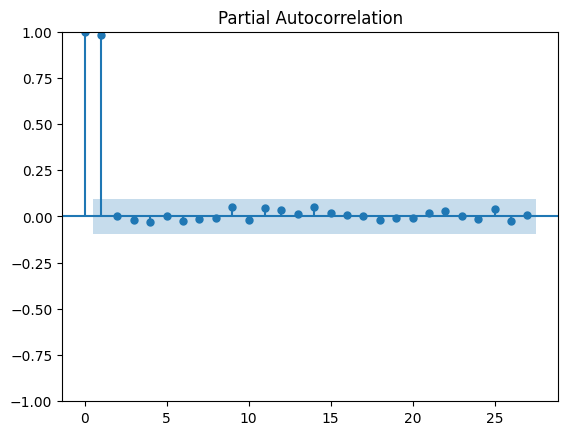

In [13]:
plot_pacf(dfi.close)
plt.show()

In [62]:
model = ARIMA(dfs.close, order=(1, 1, 1)).fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  417
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3330.834
Date:                Wed, 21 Feb 2024   AIC                           6667.669
Time:                        06:40:13   BIC                           6679.761
Sample:                             0   HQIC                          6672.450
                                - 417                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9999      0.004    239.734      0.000       0.992       1.008
ma.L1         -0.9987      0.029    -34.070      0.000      -1.056      -0.941
sigma2      5.253e+05   2.38e-08   2.21e+13      0.0

In [73]:
model = AutoARIMA(
    trace = True,
    error_action ='ignore', 
).fit( 
    y=dfs.close,
)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6667.722, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6663.883, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6664.950, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6665.089, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6667.664, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6666.741, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.253 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  417
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -3329.941
Date:                Wed, 21 Feb 2024   AIC                           6663.883
Time:                        06:42:37   BIC                           6671.944
Sample:                             0   HQIC                          6667.070
          

In [246]:
dfi_tmp = dfi.loc[dfi.index[-1] - timedelta(days=180):]

In [266]:
model = ARIMA(endog=dfi_tmp.close, order=(0, 1, 0)).fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  181
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1473.643
Date:                Sat, 17 Feb 2024   AIC                           2949.286
Time:                        19:36:42   BIC                           2952.479
Sample:                    08-21-2023   HQIC                          2950.580
                         - 02-17-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      7.519e+05      5e+04     15.048      0.000    6.54e+05     8.5e+05
Ljung-Box (L1) (Q):                   1.13   Jarque-Bera (JB):                74.52
Prob(Q):                              0.29   Pr

c:\Users\kiril\.pyenv\pyenv-win\versions\3.9.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\kiril\.pyenv\pyenv-win\versions\3.9.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\kiril\.pyenv\pyenv-win\versions\3.9.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [66]:
preds = model.get_prediction(start=len(dfs)-180, end=len(dfs)+3)
preds.conf_int()


,lower close,upper close
237,24652.545773,27496.014600
238,24611.481201,27454.939077
239,24690.573527,27534.020520
240,24711.744265,27555.180439
241,26342.072340,29185.497764
...,...,...
416,50854.318087,53696.534062
417,50922.179748,53764.391355
418,50410.243463,54433.943636
419,50034.317070,54967.470920


In [64]:
preds.predicted_mean

387    39559.236030
388    39903.841809
389    40154.550164
390    39975.860934
391    41854.100111
392    42189.481688
393    42097.523908
394    43364.079979
395    43017.297021
396    42627.604805
397    43159.713640
398    43236.718992
399    43046.099043
400    42663.048219
401    42746.199920
402    43125.274545
403    44366.428120
404    45350.123139
405    47169.360223
406    47810.077371
407    48356.209186
408    49982.677585
409    49808.752646
410    51819.447229
411    51987.437650
412    52198.888983
413    51698.882216
414    52127.230556
415    51790.531103
416    52275.426075
417    52343.285551
418    52422.093550
419    52500.893995
420    52579.686889
Name: predicted_mean, dtype: float64

In [82]:
model.predict(n_periods=1)

417    52350.19351
dtype: float64

In [250]:
dfi_tmp

,open,high,low,close,tick_volume,spread,real_volume
time,,,,,,,
2023-08-21,26195.40,26241.59,25813.54,26114.26,111115,451,0
2023-08-22,26115.14,26134.69,25363.68,26056.38,114205,453,0
2023-08-23,26057.78,26829.41,25798.39,26436.97,121132,501,0
2023-08-24,26436.63,26580.03,25861.72,26171.08,117518,300,0
2023-08-25,26170.80,26296.21,25758.53,26032.41,115801,383,0
...,...,...,...,...,...,...,...
2024-02-13,49894.69,50323.71,48278.14,49733.91,163269,1627,0
2024-02-14,49710.36,52021.73,49239.29,51740.52,172123,1626,0
2024-02-15,51768.09,52779.51,51255.39,51908.33,172251,1650,0


In [253]:
import itertools
p = range(0,10)
d = q = range(0,3)
pdq = list(itertools.product(p, d, q))
best_pdq = (0,0,0)
best_aic = np.inf
for params in pdq:
  model_test = ARIMA(dfi_tmp.close, order = params)
  result_test = model_test.fit()
  if result_test.aic < best_aic:
    best_pdq = params
    best_aic = result_test.aic
print(best_pdq, best_aic)

c:\Users\kiril\.pyenv\pyenv-win\versions\3.9.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\kiril\.pyenv\pyenv-win\versions\3.9.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\kiril\.pyenv\pyenv-win\versions\3.9.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\kiril\.pyenv\pyenv-win\versions\3.9.8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\kiril\.pyenv\pyenv-win\versions\3.9.8\lib\site-packages\statsmodels\tsa\base\tsa_mo

(0, 1, 0) 2949.2856405985003


In [48]:
def tm_plot_pred_vs_data(predictions: pd.DataFrame, true_data: pd.DataFrame, df_logs: pd.DataFrame = None, figsize: tuple[int, int] = (7, 3), xsize: int = 7):
    residuals = true_data - predictions
    
    # plot residuals
    plt.figure(figsize=figsize)
    plt.plot(residuals)
    plt.title('Residuals from AR Model')
    plt.ylabel('Error')
    plt.axhline(0, color='r', linestyle='--', alpha=0.2)
    plt.xticks(size=xsize)
    plt.show()

    # plot predictions vs true data
    plt.figure(figsize=figsize)
    plt.plot(true_data)
    plt.plot(predictions)
    if df_logs is not None:
        for i, idx in enumerate(df_logs.index):
            if df_logs.action.iloc[i].value == -1:
                plt.axvline(x=idx.to_pydatetime(), color='r')
            elif df_logs.action.iloc[i].value == 1:
                plt.axvline(x=idx.to_pydatetime(), color='b')
            else:
                plt.axvline(x=idx.to_pydatetime(), color='gray')
    plt.legend(('Data', 'Predictions'))
    plt.title('Predicted vs true data')
    plt.ylabel('data')
    plt.xticks(size=xsize)
    plt.show()


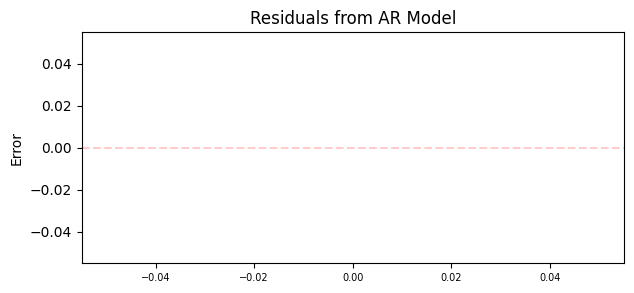

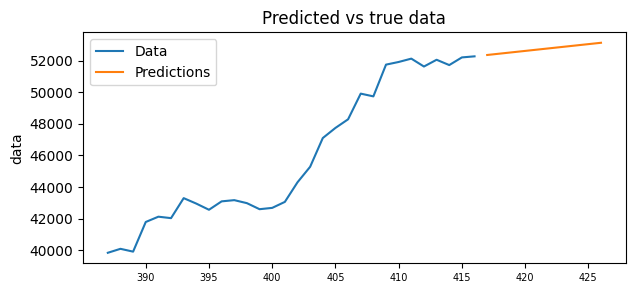

In [79]:
tm_plot_pred_vs_data(model.predict(), dfs.close[-30:])

In [278]:
model.predict()[-180:]

2024-02-08    44302.23
2024-02-09    45283.97
2024-02-10    47099.48
2024-02-11    47738.99
2024-02-12    48284.12
2024-02-13    49907.30
2024-02-14    49733.91
2024-02-15    51740.52
2024-02-16    51908.33
2024-02-17    52119.51
Freq: D, Name: predicted_mean, dtype: float64

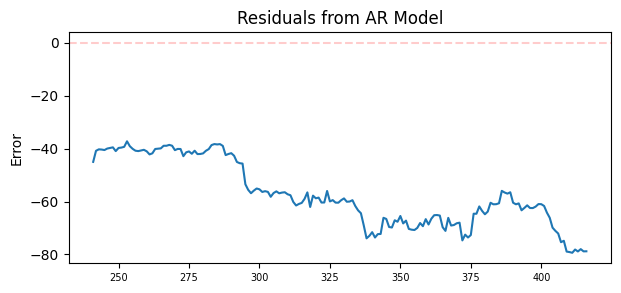

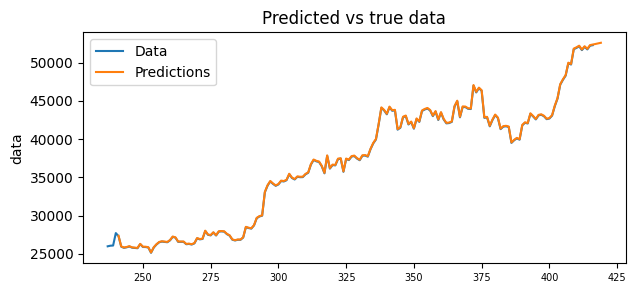

In [71]:
tm_plot_pred_vs_data(preds.predicted_mean[-180:].shift(-1), dfs.close[-180:])